In [1]:
import requests as rq
import bs4 as bs

import matplotlib.pyplot as plt
import matplotlib.style as mstyle
%matplotlib inline

import seaborn as sns
sns.set()

mstyle.use('ggplot')
sns.set_style('whitegrid')

In [2]:
from toolz.functoolz import excepts

In [3]:
from matplotlib import rcParams

rcParams['figure.figsize']  = 10, 8
rcParams['font.size']       = 16
rcParams['axes.labelsize']  = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.fontsize'] = 15

In [4]:
root = 'https://www.atositchallenge.net/students-ideas/'

soup = bs.BeautifulSoup(rq.get(root).text, 'html5lib')

data = soup.select('div.ideas-wrapper a')
len(data)

204

In [5]:
mk_safe = lambda f: excepts(Exception, f, lambda _: np.NaN)

def extract_short_info(r):
    
    get_href =  mk_safe(lambda x: x['href'])
    get_title = mk_safe(lambda x: x.select_one('div.caption-container h3').text)
    get_uni =   mk_safe(lambda x: x.select_one('div.caption-container p.university').text)
    get_flag =  mk_safe(lambda x: x.select_one('img.flag')['alt'])
    
    return {
        'url': get_href(r),
        'title': get_title(r),
        'university': get_uni(r),
        'country': get_flag(r)
    }

In [8]:
df = pd.DataFrame([extract_short_info(x) for x in data])
df.country = df.country.str.split(' ').apply(lambda x: x[-1])

In [9]:
df.head()

,country,title,university,url
0,Turkey,studentjob,Duzce University,https://www.atositchallenge.net/idea/studentjob/
1,China,Virtual screening of prodrugs,Nanjing University Of Posts And Telecommunicat...,https://www.atositchallenge.net/idea/virtual-s...
2,Singapore,AudIO,National University of Singapore,https://www.atositchallenge.net/idea/audio/
3,Singapore,HR FriendBot,National University of Singapore,https://www.atositchallenge.net/idea/hr-friend...
4,India,Smart Travel Alarm-An iOS app,anna university chennai,https://www.atositchallenge.net/idea/smart-tra...


In [10]:
df.to_csv('ideas.csv', index=False)

In [11]:
df = pd.read_csv('ideas.csv')

---

In [12]:
def download_description(title, url):
    try:
        soup = bs.BeautifulSoup(rq.get(url).text, 'html5lib')
        
        get_summary = mk_safe(lambda x: x.select_one('p.summary').text)
        get_members = mk_safe(lambda x: x.select('p.members')[0].text)
        
        summary = get_summary(soup)
        members = get_members(soup)
    except:
        return None
    return {
        'title': title,
        'summary': summary,
        'members': members
    }

In [13]:
results = list(df.apply(lambda row: download_description(row['title'], row['url']), axis=1))

df_summaries = pd.DataFrame(list(results))

In [14]:
df = df.merge(df_summaries)

In [15]:
df.shape

(204, 6)

In [16]:
df.to_csv('ideas.csv', index=False)

---

In [18]:
df.head()

,country,title,university,url,members,summary
0,Turkey,studentjob,Duzce University,https://www.atositchallenge.net/idea/studentjob/,Oguzhan Cevik | Emre Orucoglu | Mustafa Guzel,It is a platform for university students to fi...
1,China,Virtual screening of prodrugs,Nanjing University Of Posts And Telecommunicat...,https://www.atositchallenge.net/idea/virtual-s...,Wenyong Zhu | Guwei Sun | Jingzhou Yuan,With the rapid development of life sciences at...
2,Singapore,AudIO,National University of Singapore,https://www.atositchallenge.net/idea/audio/,Kai Hsien Boo | Yip Keng Kan,People from a non-English speaking country suc...
3,Singapore,HR FriendBot,National University of Singapore,https://www.atositchallenge.net/idea/hr-friend...,Say Xian Xun | Yeo York Hao,Allows effective triage and suitability of per...
4,India,Smart Travel Alarm-An iOS app,anna university chennai,https://www.atositchallenge.net/idea/smart-tra...,harini dhanasekar | srisai tejaswi | Sowmiya J...,In this modern world Smartphones and Tablets a...


In [19]:
# df.drop('number_of_members', axis=1).head()

In [20]:
counts = df.country.value_counts()

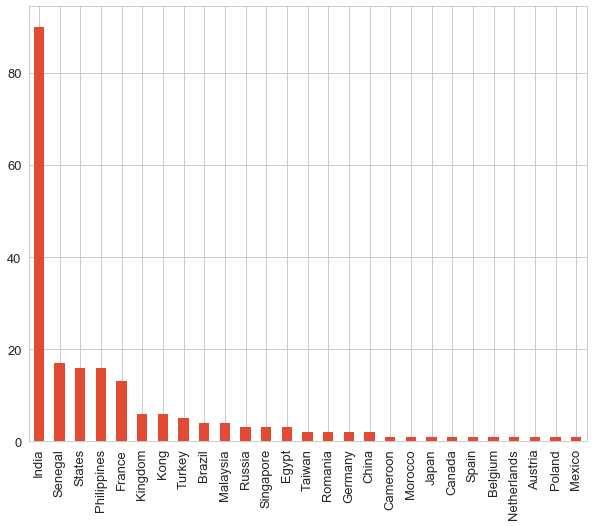

In [21]:
counts.plot.bar();

In [22]:
india_part = pd.Series(data=[counts[0], counts[1:].sum()], index=['India', 'Rest of the world'])

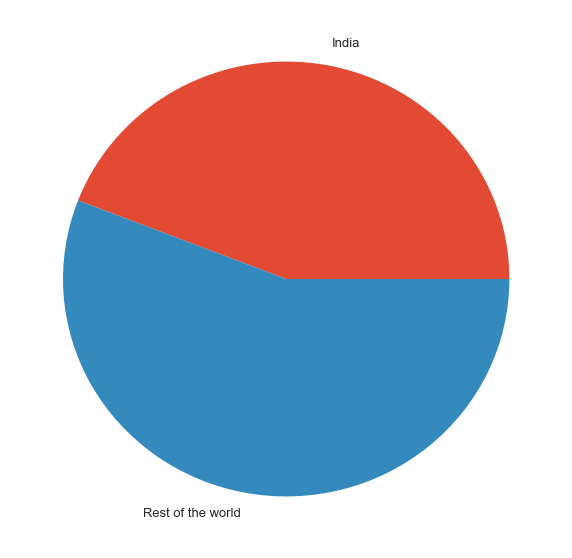

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
india_part.plot.pie(ax=ax);
ax.set_ylabel('');

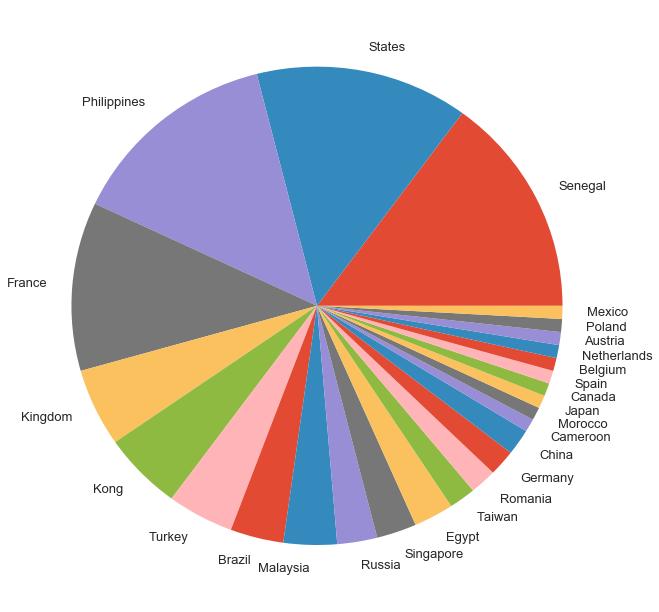

In [24]:
f, ax = plt.subplots(1, 1, figsize=(11, 11))
counts[1:].plot.pie(ax=ax);
ax.set_ylabel('');

In [25]:
university_counts = df.groupby('country')[['university']]\
    .agg('nunique')\
    .sort_values(by='university', ascending=False)

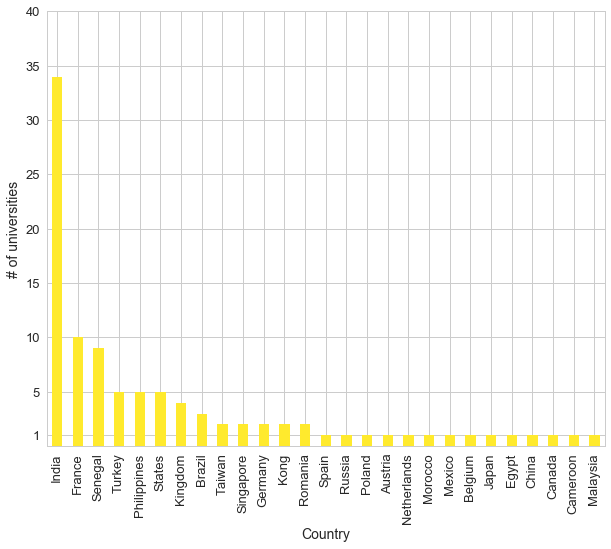

In [26]:
university_counts\
    .plot.bar(colors=['#ffea2d' if k != 'Россия' else '#ff2d2d' \
                      for k in university_counts.index]);
plt.gca().legend_.remove()
plt.ylabel('# of universities');
plt.xlabel('Country');
y_ticks = list(plt.yticks()[0])
y_ticks.remove(0)
plt.yticks(y_ticks + [1]);

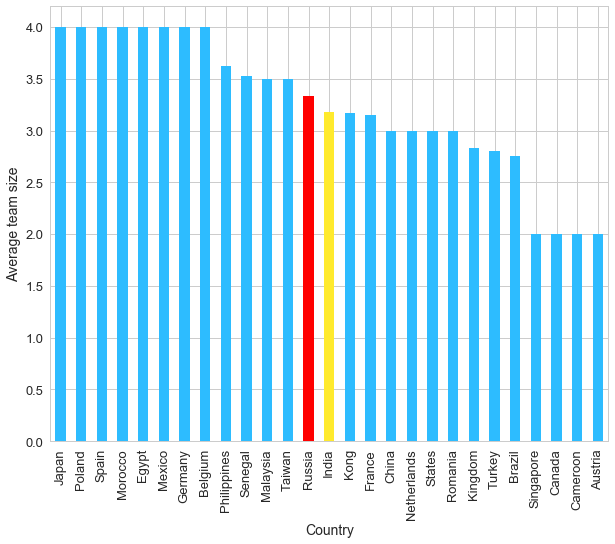

In [27]:
df['number_of_members'] = df.members.str.split('|').apply(lambda x: len(x))
avg_members = df.groupby('country').agg('mean').sort_values(by='number_of_members', ascending=False)

avg_members.plot.bar(colors=['r' if x=='Russia' else ('#2dbcff' if x != 'India' else '#ffea2d') for x in avg_members.index]);
plt.gca().legend_.remove()
plt.xlabel('Country');
plt.ylabel('Average team size');

# Text

## Titles

In [28]:
import re

from nltk import word_tokenize

from nltk.corpus import stopwords
from nltk import FreqDist

In [29]:
titles = ' '.join(df.title.values)
tokens = [x.lower() for x in word_tokenize(titles) if re.match("[a-zA-Z\d]+", x) is not None]
tokens = [x for x in tokens if x not in stopwords.words('english')]

fd = FreqDist(tokens)
[fd.pop(x) for x in ['chatbot', 'bot', 'service', 'ai', 'virtual', 'companion', 'system', 
                     'app', 'intelligent', 'chatbots', 'robot', 'assistant', 'smart', 'solutions']];
len(fd) # 328

328

Most frequent words used in titles:

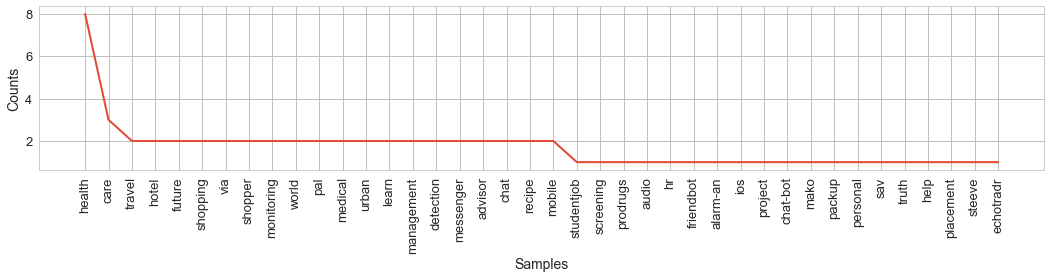

In [31]:
plt.figure(figsize=(18, 3));
fd.plot(40, cumulative=False)

----

## Description texts

In [32]:
from nltk import SnowballStemmer

In [33]:
summaries = '. '.join(df.summary)

sbs = SnowballStemmer('english')

tokens = [x.lower() for x in word_tokenize(summaries) if re.match("[a-zA-Z\d]+", x) is not None]
tokens = [x for x in tokens if x not in stopwords.words('english')] # 18546
tokens = [sbs.stem(x) for x in tokens]

len(tokens) # 18623

fd = FreqDist(tokens)
len(fd) # -> 3301, w/o stemming 4877

3316

Most frequent words used in descriptions:

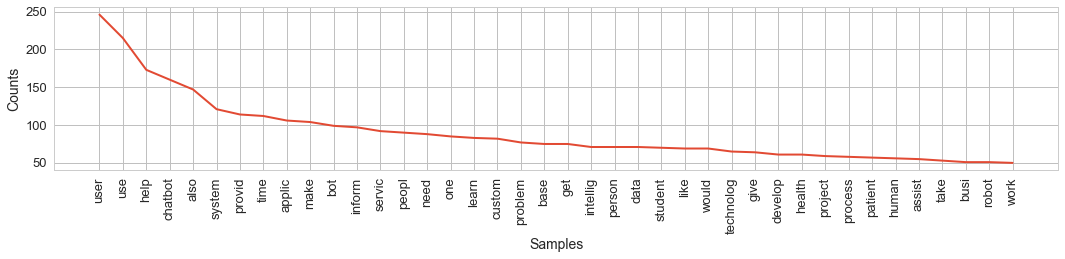

In [34]:
plt.figure(figsize=(18, 3));
fd.plot(40, cumulative=False)

---

# Summarization

In [35]:
from gensim.summarization import summarize, keywords

In [36]:
len(summaries)

207991

In [37]:
print(summarize(summaries, word_count=150))

Its a virtual travel assistant that provides on demand feed,notifications and data according to customization(location,eating preferences,age etc.)It takes the necessary data and takes the interests from the social media of a person and provides the chat to him in the same manner Chatbot serves the data ranging from flight details,cab facility to location (precise timings,photos,guide,weather etc which makes the travel more sensible and by pinning points and tracking journey it saves  a lot of money too),markets( helps  to walk through markets and worth buying prices )or it may be a nightlife .


In [38]:
ks = keywords(summaries, words=30, lemmatize=True)
for i, x in enumerate(ks.split('\n')):
    ending = '\t' if (i+1) % 4 != 0 else '\n'
    print(x.ljust(14), end=ending)

likely        	users         	inform        	helped        
basing        	provider      	chatbotics    	servicing     
humanity      	timings       	persons       	people        
data          	uses          	learns        	applicants    
news          	medications   	health        	differences   
technological 	problems      	customization 	businesses    
bots          	experiences   	foods         	student       
processed     	

---

# New ideas generating!

In [40]:
import markovify

markov = markovify.Text(summaries)

In [41]:
for i in range(10):
    print(markov.make_sentence())

If it exceeds threshold level it will automatically add it to the user.
However, the establishment of a chapter if the student along his school curriculum to guarantee him the same way.
But when you have to do your chores, but more like you do not know how your hall or your calendar and presents her results via a chat between chatbots!. Application that helps the user can send a picture is taken by the AI has proposed.
Recipe House utilizes AI and Chatbots, it will be a interface between the patient really was sent to the physically disabled people.
Our App “Health Abroad” uses the Chat-Bots to give aids to the right prices to earn more and more over this Villon is friendly to all those who have access to health information and feel in secured in hospitals as the less queued one.
It can adapt to various situations with its ever expanding knowledge and experiences and can be used for decision support system based upon his skills and other machine learning algorithms.
These technologies 

In [42]:
for i in range(5):
    print(markov.make_sentence_with_start('The bot'))

The bot thus realized, it will use AI chatbots.
The bot will provide an intellectual stimuli by striking conversation on a map the correlation with the help of those who are more aware about the design of a new reservation channel, which will help in elaborating story elements and ask meaningful questions towards scaffolding and collaborative learning..
The bot will completely take over the phone to the applicants.
The bot will respond with sentences like “What are the head and the geolocation of existing health structures.
The bot registers new users and corporate businesses alike, for the learners.


In [43]:
for i in range(5):
    print(markov.make_sentence_with_start('You can'))

You can get a detailed events or incident report using the android App.
You can be consulted at any time, but on average, first appears during the stay.
You can be heard through an app.
You can just waltz in to a large number of items and SKUs to manage their booking or reservation from customer or browse the rating of their android phone to have the message with the cost of Clever-Order is much easier for both users.
You can be divided into two sections: 1.


In [44]:
for i in range(5):
    print(markov.make_sentence_with_start('It helps'))

It helps students to be translated.
It helps students about course selections, major choices, career possibilities and present the best economic policy for that country.
It helps students to find out about training courses, competitions, job offers, internships, scholarship etc. The app will use machine learning methods have been doing, mostly, manual, verification to the focus on actual diagnosis.
It helps students to find local hospitals that are lacking.
It helps students about course selections, major choices, career possibilities and present the best teams in the block.


In [45]:
for i in range(5):
    print(markov.make_sentence_with_start('Users'))

Users will be much better spent elsewhere.
Users can through the app.
Users can not only the current news based trends which may contribute to reduce the stress and trouble for the competitive advantage of businesses across the city as Ai-City being a prime example of what we can be temporary or permanent, and may be by a student, the correction of the incident, there is a highly personalized food recommending smart chat-bot which has poor user friendliness and difficult to access database to answer to the world and diseases related to depression..
Users can through the chatbot is an application that allows assisted medical diagnosis with capabilities for bridging the patient asks him the best buddy.
Users can not only the IT industry but also to be those who are not satisfied.


---

# Wordcloud

In [46]:
from wordcloud import WordCloud

from PIL import Image

In [47]:
mask_image = Image.open("mask.png")
mask = np.array(mask_image)

wordcloud = WordCloud(background_color="white", colormap='plasma',
                      width=mask_image.width, height=mask_image.height,
                      max_words=2000, mask=mask, 
                      stopwords=stopwords.words('english'))

wordcloud.generate(summaries);

In [48]:
wordcloud.to_file("cloud.png");

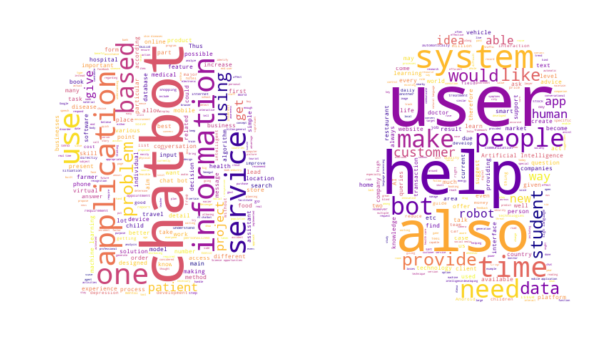

In [49]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()